# Load Data

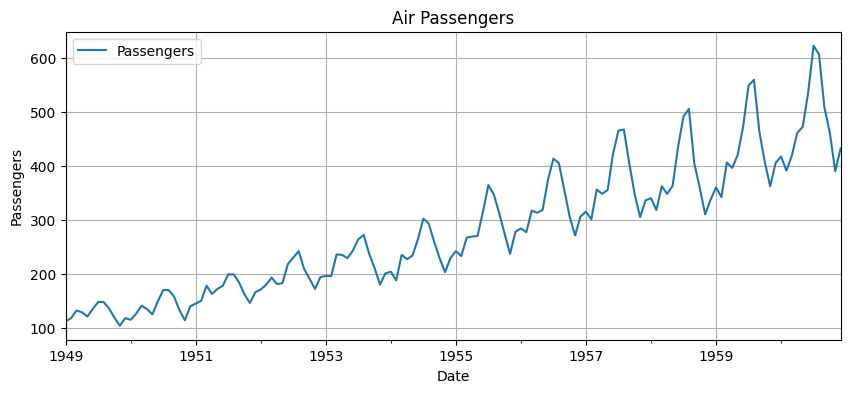

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")


# Load the AirPassengers dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

# Visualize the series
df.plot(figsize=(10, 4), title="Air Passengers")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.grid()
plt.show()

# Split Data

In [2]:
def create_time_series_features(data, lookback_window=12):
    """
    Create features for time series forecasting using lagged values
    """
    X, y = [], []
    
    for i in range(lookback_window, len(data)):
        # Use previous 'lookback_window' values as features
        X.append(data[i-lookback_window:i])
        y.append(data[i])
    
    return np.array(X), np.array(y)

In [3]:
lag = 12
X = df['Passengers'][:-lag]
y = df['Passengers'][lag:]

# Define sizes
n = len(X)
train_size = int(n * 0.7)
val_size = int(n * 0.15)
test_size = n - train_size - val_size

# Split the series
data = {
    'X_train': X[:train_size],
    'y_train': y[:train_size],
    'X_val': X[train_size:train_size + val_size],
    'y_val': y[train_size:train_size + val_size],
    'X_test': X[train_size + val_size:],
    'y_test': y[train_size + val_size:]
}

# Confirm sizes
print(f"Train size: {len(data['X_train'])}, Val size: {len(data['X_val'])}, Test size: {len(data['X_test'])}")

Train size: 92, Val size: 19, Test size: 21


In [4]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

data['X_train_scaled'] = scaler_X.fit_transform(np.array(data['X_train']).reshape(-1,1))
data['X_val_scaled'] = scaler_X.transform(np.array(data['X_val']).reshape(-1,1))
data['y_train_scaled'] = scaler_y.fit_transform(np.array(data['y_train']).reshape(-1, 1)).ravel()
data['y_val_scaled'] = scaler_y.transform(np.array(data['y_val']).reshape(-1, 1)).ravel()
# X_test_scaled = 
# y_test_scaled = 


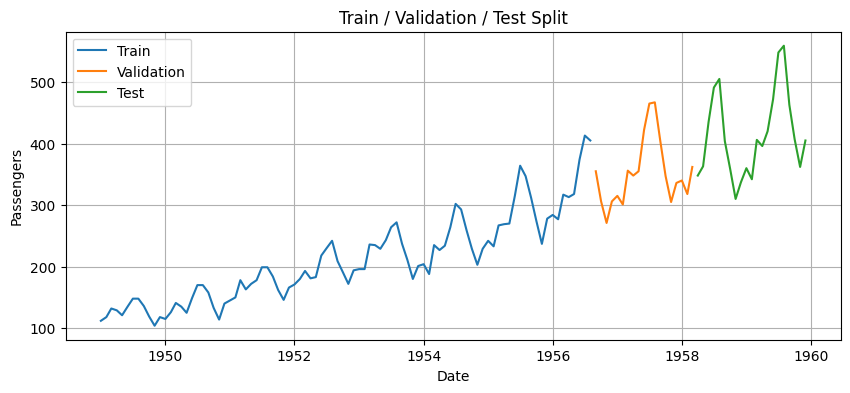

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(data['X_train'], label="Train")
plt.plot(data['X_val'], label="Validation")
plt.plot(data['X_test'], label="Test")
plt.title("Train / Validation / Test Split")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.grid()
plt.show()

# Base Models

In [28]:
from abc import ABC, abstractmethod
from statsmodels.tsa.arima.model import ARIMA
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


class AbstractBaseModel (ABC):

    def __init__(self, model, hparams, *args, **kwagrs):
        self.model = model
        self.hparams = hparams
        self.fitness_score = 0.0
        self.forecast = None

    @abstractmethod
    def train(self, X_train, y_train):
        pass

    @abstractmethod
    def predict(self, X_test):
        pass

    @abstractmethod
    def get_name(self):
        pass
    
    def calculate_fitness(self, pred, y_test):
        self.fitness_score = 1/(np.sqrt(mean_squared_error(y_test, pred)) + 1e-8)
        return self.fitness_score
    
    def __str__(self):
        return str(type(self).__name__) + ' ' + str(self.hparams) + ' Fitness: ' + str(self.fitness_score)
    
    def __repr__(self):
        return str(type(self).__name__) + ' ' + str(self.hparams) + ' Fitness: ' + str(self.fitness_score)

class ArimaModel(AbstractBaseModel):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def train(self, X_train, y_train):
        p = self.hparams['p']
        d = self.hparams['d']
        q = self.hparams['q']
        self.model = ARIMA(X_train, order=(p, d, q)).fit()
    
    def predict(self, X_test):
        self.forecast = self.model.forecast(steps=len(X_test))
        return self.forecast
    
    @classmethod
    def get_name(cls):
        return 'arima'

class SVRModel (AbstractBaseModel):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def train(self, X_train, y_train):
        kernel = self.hparams['kernel']
        c = self.hparams['c']
        gamma = self.hparams['gamma']
        epsilon = self.hparams['epsilon']
        self.model = SVR(kernel=kernel, C=c, gamma=gamma, epsilon=epsilon)
        self.model.fit(X_train, y_train)
    
    def predict(self, X_test):
        self.forecast = self.model.predict(X_test)
        return self.forecast
    
    @classmethod
    def get_name(cls):
        return 'svr'
    
class MLPModel (AbstractBaseModel):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def train(self, X_train, y_train):
        hidden_layer_sizes = self.hparams['hidden_layer_sizes']
        learning_rate = self.hparams['learning_rate']
        
        hidden_layer_sizes = (int(hidden_layer_sizes),)
        
        self.model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                            learning_rate_init=learning_rate,
                            max_iter=500, random_state=42)
        self.model.fit(X_train, y_train)
    
    def predict(self, X_test):
        self.forecast = self.model.predict(X_test)
        return self.forecast
    
    @classmethod
    def get_name(cls):
        return 'mlp'
    
class EnsembleModel (AbstractBaseModel):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def train(self, X_train, y_train):
        for model in self.hparams.keys():
            self.hparams[model].train(X_train, y_train)
    
    def predict(self, X_test):
        self.forecast = 0.0
        for model in self.hparams.keys():
            self.forecast += self.hparams[model].predict(X_test)
        self.forecast /= len(self.hparams.keys()) # Average of all predictions
        return self.forecast
    
    @classmethod
    def get_name(cls):
        return 'ensemble'


In [7]:
pool_of_models = [ArimaModel, SVRModel, MLPModel]

def print_population(population):
    for model in population.keys():
        for individual in population[model]:
            print(individual)
    print('============================\n\n')


def init_population(population_size):
    population = {}

    for model in pool_of_models:
        population[model.get_name()] = []
        if model is ArimaModel:
            for _ in range(population_size):
                population[model.get_name()].append(
                    ArimaModel(
                        ARIMA,
                        {
                            'p': np.random.randint(0, 5),
                            'd': np.random.randint(0, 2),
                            'q': np.random.randint(0, 5)
                        }
                    )
                )
        elif model is SVRModel:
            for _ in range(population_size):
                population[model.get_name()].append(
                    SVRModel(
                        SVR,
                        {
                            'kernel' : np.random.choice(["linear", "rbf", "poly"]),
                            'c' : np.random.uniform(0.1, 100),
                            'gamma': np.random.choice(['scale']),
                            'epsilon' : np.random.uniform(0.001, 0.5)
                        }
                    )
                )
        elif model is MLPModel:
            for _ in range(population_size):
                population[model.get_name()].append(
                    MLPModel(
                        MLPRegressor,
                        {
                            'hidden_layer_sizes': np.random.randint(5, 50),
                            'learning_rate': np.random.uniform(0.001, 0.1)
                        }
                    )
                )
    
    return population

In [8]:
population_size = 5
num_generations = 20
mutation_rate = 0.2

print('Initializing population...')
population = init_population(population_size)

print('Population created: ')
print_population(population)

Initializing population...
Population created: 
ArimaModel {'p': 3, 'd': 0, 'q': 2} Fitness: 0.0
ArimaModel {'p': 0, 'd': 0, 'q': 1} Fitness: 0.0
ArimaModel {'p': 4, 'd': 0, 'q': 2} Fitness: 0.0
ArimaModel {'p': 4, 'd': 1, 'q': 4} Fitness: 0.0
ArimaModel {'p': 3, 'd': 1, 'q': 0} Fitness: 0.0
SVRModel {'kernel': 'rbf', 'c': 61.04319196687145, 'gamma': 'scale', 'epsilon': 0.47100348064193687} Fitness: 0.0
SVRModel {'kernel': 'rbf', 'c': 10.684923844936774, 'gamma': 'scale', 'epsilon': 0.2516824362882931} Fitness: 0.0
SVRModel {'kernel': 'linear', 'c': 87.24159288817378, 'gamma': 'scale', 'epsilon': 0.4910403854971883} Fitness: 0.0
SVRModel {'kernel': 'linear', 'c': 97.27661930684103, 'gamma': 'scale', 'epsilon': 0.4124953925989804} Fitness: 0.0
SVRModel {'kernel': 'linear', 'c': 32.26532133810758, 'gamma': 'scale', 'epsilon': 0.3208601949947794} Fitness: 0.0
MLPModel {'hidden_layer_sizes': 12, 'learning_rate': 0.03413999425037892} Fitness: 0.0
MLPModel {'hidden_layer_sizes': 29, 'learnin

In [9]:
def individual_evaluation(population, data):
    X_train = data['X_train_scaled']
    y_train = data['y_train_scaled']
    X_val = data['X_val_scaled']
    y_val = data['y_val_scaled']


    for model in population.keys():
        for individual in population[model]:
            individual.train(X_train, y_train)
            pred = individual.predict(X_val)
            individual.calculate_fitness(pred, y_val)
            
    

In [10]:
individual_evaluation(population, data)

/Users/fcma/workspace/personal/Cooperative-Coevolutionary-Algorithms-for-Model-Diversity/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/fcma/workspace/personal/Cooperative-Coevolutionary-Algorithms-for-Model-Diversity/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/fcma/workspace/personal/Cooperative-Coevolutionary-Algorithms-for-Model-Diversity/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [11]:
print_population(population)

ArimaModel {'p': 3, 'd': 0, 'q': 2} Fitness: 1.1216317236859532
ArimaModel {'p': 0, 'd': 0, 'q': 1} Fitness: 0.5733376026247498
ArimaModel {'p': 4, 'd': 0, 'q': 2} Fitness: 1.320125075052109
ArimaModel {'p': 4, 'd': 1, 'q': 4} Fitness: 1.7860077521791637
ArimaModel {'p': 3, 'd': 1, 'q': 0} Fitness: 0.8282469370695406
SVRModel {'kernel': 'rbf', 'c': 61.04319196687145, 'gamma': 'scale', 'epsilon': 0.47100348064193687} Fitness: 1.6279935805953096
SVRModel {'kernel': 'rbf', 'c': 10.684923844936774, 'gamma': 'scale', 'epsilon': 0.2516824362882931} Fitness: 1.5792595236206455
SVRModel {'kernel': 'linear', 'c': 87.24159288817378, 'gamma': 'scale', 'epsilon': 0.4910403854971883} Fitness: 5.006502262383493
SVRModel {'kernel': 'linear', 'c': 97.27661930684103, 'gamma': 'scale', 'epsilon': 0.4124953925989804} Fitness: 4.103614523545324
SVRModel {'kernel': 'linear', 'c': 32.26532133810758, 'gamma': 'scale', 'epsilon': 0.3208601949947794} Fitness: 3.6778798307539393
MLPModel {'hidden_layer_sizes': 

In [ ]:
from itertools import combinations


def calculate_model_diversity(models_dict, X_test):
    """
    Calculate disagreement measure (diversity) for ensemble models using MSE.
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary with model names as keys and trained model objects as values
        Format: {'model_name': model_object, ...}
    X_test : array-like
        Test data for generating predictions
    
    Returns:
    --------
    float : Average disagreement measure across all model pairs
    dict : Dictionary with detailed diversity metrics and model predictions
    """
    
    if len(models_dict) < 2:
        raise ValueError("Need at least 2 models to calculate diversity")
    
    # Get predictions from all models
    model_predictions = {}
    model_names = []
    
    # print("Generating predictions from individual models...")
    for model_name, model_obj in models_dict.items():
        predictions = model_obj.predict(X_test)
        model_predictions[model_name] = predictions
        model_names.append(model_name)
        # print(f"  {model_name}: predictions generated")
    
    # Convert to numpy array for easier computation
    pred_matrix = np.column_stack([model_predictions[name] for name in model_names])
    n_models = len(model_names)
    
    # Calculate pairwise disagreements using MSE
    pairwise_disagreements = []
    disagreement_matrix = np.zeros((n_models, n_models))
    model_pairs = []
    
    # print("\nCalculating pairwise disagreements...")
    for i, j in combinations(range(n_models), 2):
        model_i = model_names[i]
        model_j = model_names[j]
        pred_i = pred_matrix[:, i]
        pred_j = pred_matrix[:, j]
        
        disagreement = mean_squared_error(pred_i, pred_j)
        pairwise_disagreements.append(disagreement)
        disagreement_matrix[i, j] = disagreement
        disagreement_matrix[j, i] = disagreement  # Symmetric matrix
        model_pairs.append((model_i, model_j))
        
        print(f"  {model_i} vs {model_j}: MSE = {disagreement:.6f}")
    
    # Calculate overall diversity measure
    avg_disagreement = np.mean(pairwise_disagreements)
    
    # Additional diversity statistics
    diversity_stats = {
        'average_disagreement': avg_disagreement,
        'pairwise_disagreements': pairwise_disagreements,
        'disagreement_matrix': disagreement_matrix,
        'model_pairs': model_pairs,
        'min_disagreement': np.min(pairwise_disagreements),
        'max_disagreement': np.max(pairwise_disagreements),
        'std_disagreement': np.std(pairwise_disagreements),
        'n_pairs': len(pairwise_disagreements),
        'model_names': model_names,
        'individual_predictions': model_predictions
    }
    
    return avg_disagreement, diversity_stats

In [ ]:
def team_evaluation(population, X_test, y_test):
    alpha = 0.8
    beta = 0.2

    best_models = {}
    # Select the best individual of each subpopulation
    for model in population.keys():
        best_ind = None
        for individual in population[model]:
            best_ind = individual if best_ind is None or individual.fitness_score > best_ind.fitness_score else best_ind
        
        best_models[best_ind.get_name()] = best_ind
    
    ensemble = EnsembleModel(None, best_models)
    pred = ensemble.predict(X_test)

    diversity_score, _ = calculate_model_diversity(best_models, X_test)
    
    fitness_score = (alpha * (1/(np.sqrt(mean_squared_error(pred, y_test) + 1e-8)))) + (beta * diversity_score)

    return fitness_score, best_models, pred, ensemble, fitness_score


In [39]:
a, pred, ensemble, fit = team_evaluation(population, data['X_val_scaled'], data['y_val_scaled'])
a

{'arima': ArimaModel {'p': 4, 'd': 1, 'q': 4} Fitness: 1.7860077521791637,
 'svr': SVRModel {'kernel': 'linear', 'c': 87.24159288817378, 'gamma': 'scale', 'epsilon': 0.4910403854971883} Fitness: 5.006502262383493,
 'mlp': MLPModel {'hidden_layer_sizes': 12, 'learning_rate': 0.03413999425037892} Fitness: 3.4137292597615425}

In [47]:
a['ensemble'] = ensemble

In [49]:
fit

3.2555178357897496

In [54]:
a

{'arima': ArimaModel {'p': 4, 'd': 1, 'q': 4} Fitness: 1.7860077521791637,
 'svr': SVRModel {'kernel': 'linear', 'c': 87.24159288817378, 'gamma': 'scale', 'epsilon': 0.4910403854971883} Fitness: 5.006502262383493,
 'mlp': MLPModel {'hidden_layer_sizes': 12, 'learning_rate': 0.03413999425037892} Fitness: 3.4137292597615425}

In [56]:
calculate_model_diversity(a, data['X_val_scaled'])

Generating predictions from individual models...
  arima: predictions generated
  svr: predictions generated
  mlp: predictions generated

Calculating pairwise disagreements...
  arima vs svr: MSE = 0.222855
  arima vs mlp: MSE = 0.211697
  svr vs mlp: MSE = 0.033874


(0.1561422152603071,
 {'average_disagreement': 0.1561422152603071,
  'pairwise_disagreements': [0.22285543324080442,
   0.21169725246290594,
   0.03387396007721101],
  'disagreement_matrix': array([[0.        , 0.22285543, 0.21169725],
         [0.22285543, 0.        , 0.03387396],
         [0.21169725, 0.03387396, 0.        ]]),
  'model_pairs': [('arima', 'svr'), ('arima', 'mlp'), ('svr', 'mlp')],
  'min_disagreement': 0.03387396007721101,
  'max_disagreement': 0.22285543324080442,
  'std_disagreement': 0.08657663625831585,
  'n_pairs': 3,
  'model_names': ['arima', 'svr', 'mlp'],
  'individual_predictions': {'arima': array([2.38086824, 1.94219249, 1.57559187, 1.38367429, 1.39619631,
          1.60472262, 1.93880749, 2.30965017, 2.61628707, 2.78694705,
          2.78315488, 2.61859767, 2.34285533, 2.03517754, 1.77466577,
          1.62694605, 1.62183875, 1.75351217, 1.97893071]),
   'svr': array([1.76201136, 1.17158213, 0.74984697, 1.17158213, 1.28002832,
          1.11133425, 1.7740

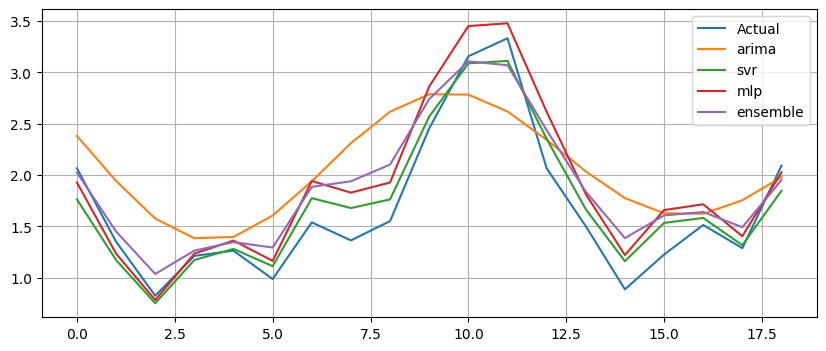

In [51]:
def plot_forecasts(models, actual):
    plt.figure(figsize=(10, 4))
    plt.plot(actual, label='Actual')
    for model in models:
        plt.plot(model.forecast, label= model.get_name())
    # plt.xlabel("Date")
    # plt.ylabel("Passengers")
    plt.grid()
    plt.legend()
    plt.show()

plot_forecasts(a.values(), data['y_val_scaled'])


In [ ]:

# Loop CCEA
for generation in range(num_generations):

    # Individual evaluation
    individual_evaluation(population, data)



    for i in range(tamanho_pop):
        fit_arima, fit_rf, fit_mlp = avaliar_individual(populacao['arima'][i], populacao['rf'][i], populacao['mlp'][i], data)
        fitness_arima[i] = fit_arima
        fitness_rf[i] = fit_rf
        fitness_mlp[i] = fit_mlp

    # Avaliação cooperativa
    fitness = avaliar_cooperativo(fitness_arima, fitness_rf, fitness_mlp, populacao)
    print(f"Geração {geracao + 1}: Melhor fitness = {fitness:.5f}")

    # Seleção por torneio
    populacao['arima'] = torneio(populacao['arima'], fitness_arima)
    populacao['rf'] = torneio(populacao['rf'], fitness_rf)
    populacao['mlp'] = torneio(populacao['mlp'], fitness_mlp)

    # Cruzamento
    def crossover_populacao(pop, modelo):
        nova_pop = []
        for i in range(0, len(pop), 2):
            if i + 1 < len(pop):
                f1, f2 = cruzar(np.array(pop[i]), np.array(pop[i + 1]), modelo)
                nova_pop.extend([f1, f2])
            else:
                nova_pop.append(pop[i])
        return nova_pop

    populacao['arima'] = crossover_populacao(populacao['arima'], "arima")
    populacao['rf'] = crossover_populacao(populacao['rf'], "rf")
    populacao['mlp'] = crossover_populacao(populacao['mlp'], "mlp")

    # Mutação
    populacao['arima'] = [mutar(ind, "arima", taxa_mutacao) for ind in populacao['arima']]
    populacao['rf'] = [mutar(ind, "rf", taxa_mutacao) for ind in populacao['rf']]
    populacao['mlp'] = [mutar(ind, "mlp", taxa_mutacao) for ind in populacao['mlp']]


print("\nMelhores indivíduos e fitness finais:")
best_arima = np.argmax(fitness_arima)
best_rf = np.argmax(fitness_rf)
best_mlp = np.argmax(fitness_mlp)
print("ARIMA:", populacao['arima'][best_arima]) #, "Fitness:", fitness_arima[idx_best])
print("RF:", populacao['rf'][best_rf]) #, "Fitness:", fitness_rf[idx_best])
print("MLP:", populacao['mlp'][best_mlp]) #, "Fitness:", fitness_mlp[idx_best])


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import warnings

warnings.filterwarnings("ignore")


def train_rf(hparams, X_train, y_train):
    n_estimators, max_depth = map(int, hparams)
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    return model

def predict_rf(model, X):
    return model.predict(X)

def train_mlp(hparams, X_train, y_train):
    hidden_layer_sizes, learning_rate_init = hparams
    hidden_layer_sizes = (int(hidden_layer_sizes),)
    model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                         learning_rate_init=learning_rate_init,
                         max_iter=500, random_state=42)
    model.fit(X_train, y_train)
    return model

def predict_mlp(model, X):
    return model.predict(X)

def criar_serie(serie, lag=3):
    df_f = pd.DataFrame()
    for i in range(1, lag + 1):
        df_f[f'lag_{i}'] = serie.shift(i)
    df_f['target'] = serie.values
    df_f = df_f.dropna()
    X = df_f.drop('target', axis=1).values
    y = df_f['target'].values
    return X, y

In [10]:
def criar_populacao_inicial(tamanho_pop, modelo):
    subpopulacao = []
    if modelo == "arima":
        for _ in range(tamanho_pop):
            individuo = [
                np.random.randint(0, 5),  # p
                np.random.randint(0, 2),  # d
                np.random.randint(0, 5)   # q
            ]
            subpopulacao.append(individuo)
    elif modelo == "rf":
        for _ in range(tamanho_pop):
            individuo = [
                np.random.randint(10, 200), # n_estimators
                np.random.randint(2, 20), # max_depth
                np.random.randint(2, 10) # min_samples_split
            ]
            subpopulacao.append(individuo)
    elif modelo == "svr":
        for _ in range(tamanho_pop):
            individuo = [
                np.random.uniform(0.1, 100), # C
                np.random.uniform(0.001, 0.5), # epsilon
                np.random.choice(["linear", "rbf", "poly"]) # kernel
            ]
    elif modelo == "mlp":
        for _ in range(tamanho_pop):
            individuo = [
                np.random.randint(5, 50),          # hidden_layer_sizes
                np.random.uniform(0.001, 0.1)    # learning_rate_init
            ]
            subpopulacao.append(individuo)
    return subpopulacao

In [7]:
def torneio(populacao, fitnesses, tamanho_torneio=3):
    selecionados = []
    n = len(populacao)
    for _ in range(n):
        competidores = np.random.choice(range(n), tamanho_torneio, replace=False)
        fitness_comp = [fitnesses[i] for i in competidores]
        vencedor = competidores[np.argmax(fitness_comp)]
        selecionados.append(populacao[vencedor])
    return selecionados


def cruzar(ind1, ind2, modelo):
    ponto = np.random.randint(1, len(ind1))
    filho1 = np.concatenate((ind1[:ponto], ind2[ponto:]))
    filho2 = np.concatenate((ind2[:ponto], ind1[ponto:]))

    # Ajustar tipos após cruzamento
    if modelo == "arima":
        filho1 = [int(round(x)) for x in filho1]
        filho2 = [int(round(x)) for x in filho2]
    elif modelo == "rf":
        filho1 = [int(round(filho1[0])), int(round(filho1[1]))]
        filho2 = [int(round(filho2[0])), int(round(filho2[1]))]
    elif modelo == "mlp":
        filho1 = [int(round(filho1[0])), float(filho1[1])]
        filho2 = [int(round(filho2[0])), float(filho2[1])]

    return filho1, filho2


def mutar(ind, modelo, taxa_mutacao=0.1):
    ind_mut = ind.copy()
    for i in range(len(ind_mut)):
        if np.random.rand() < taxa_mutacao:
            if modelo == "arima":
                # p,d,q limites
                limites = [(0, 2), (0, 1), (0, 2)]
                ind_mut[i] = np.random.randint(limites[i][0], limites[i][1] + 1)
            elif modelo == "rf":
                if i == 0:  # n_estimators
                    ind_mut[i] = np.random.randint(10, 100)
                else:  # max_depth
                    ind_mut[i] = np.random.randint(2, 10)
            elif modelo == "mlp":
                if i == 0:  # hidden_layer_sizes
                    ind_mut[i] = np.random.randint(5, 50)
                else:  # learning_rate_init
                    ind_mut[i] = np.random.uniform(0.0001, 0.1)
    return ind_mut

In [25]:
def avaliar_individual(arima_ind, rf_ind, mlp_ind, data):
    train_series = data["train"]['Passengers']
    val_series = data["val"]['Passengers']
    steps = len(val_series)


    lag = 3
    X_train, y_train = criar_serie(train_series, lag)
    X_val, y_val = criar_serie(pd.concat([train_series.tail(lag), val_series]), lag)

    # Treina ARIMA
    try:
        arima_model = train_arima(arima_ind, train_series)
        arima_pred = predict_arima(arima_model, steps)
    except:
        arima_pred = np.full(steps, np.mean(train_series))  # fallback

    # Treina RF
    try:
        rf_model = train_rf(rf_ind, X_train, y_train)
        rf_pred = predict_rf(rf_model, X_val)
    except:
        rf_pred = np.full(len(y_val), np.mean(y_train))  # fallback

    # Treina MLP
    try:
        mlp_model = train_mlp(mlp_ind, X_train, y_train)
        mlp_pred = predict_mlp(mlp_model, X_val)
    except:
        mlp_pred = np.full(len(y_val), np.mean(y_train))  # fallback

    # Fitness individual
    fit_arima = 1/(np.sqrt(mean_squared_error(y_val, arima_pred)) + 1e-8)
    fit_rf = 1/(np.sqrt(mean_squared_error(y_val, rf_pred)) + 1e-8)
    fit_mlp = 1/(np.sqrt(mean_squared_error(y_val, mlp_pred)) + 1e-8)

    return fit_arima, fit_rf, fit_mlp

In [8]:
def calcula_diversidade(pred):
    df = pd.DataFrame(pred)

    # Matriz de correlação
    corr_matrix = df.corr().abs()
    
    # Remove a diagonal (correlação de 1 consigo mesmo)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    corr_vals = corr_matrix.where(~mask)
    
    # Agrega valores (exclui NaNs)
    mean_corr = corr_vals.stack().mean()

    return mean_corr

In [9]:
def avaliar_cooperativo(fitness_arima, fitness_rf, fitness_mlp, populacao):
    best_arima = np.argmax(fitness_arima)
    best_rf = np.argmax(fitness_rf)
    best_mlp = np.argmax(fitness_mlp)

    print('Best: ')
    print(str(populacao['arima'][best_arima]) + ': ' + str(fitness_arima[best_arima]))
    print(str(populacao['rf'][best_rf]) + ': ' + str(fitness_rf[best_rf]))
    print(str(populacao['mlp'][best_mlp]) + ': ' + str(fitness_mlp[best_mlp]))
    print ('=================')

    train_series = data["train"]['Passengers']
    val_series = data["val"]['Passengers']
    steps = len(val_series)


    lag = 3
    X_train, y_train = criar_serie(train_series, lag)
    X_val, y_val = criar_serie(pd.concat([train_series.tail(lag), val_series]), lag)

    # Treina ARIMA
    try:
        arima_model = train_arima(populacao['arima'][best_arima], train_series)
        arima_pred = predict_arima(arima_model, steps)
    except:
        arima_pred = np.full(steps, np.mean(train_series))  # fallback

    # Treina RF
    try:
        rf_model = train_rf(populacao['rf'][best_rf], X_train, y_train)
        rf_pred = predict_rf(rf_model, X_val)
    except:
        rf_pred = np.full(len(y_val), np.mean(y_train))  # fallback

    # Treina MLP
    try:
        mlp_model = train_mlp(populacao['mlp'][best_mlp], X_train, y_train)
        mlp_pred = predict_mlp(mlp_model, X_val)
    except:
        mlp_pred = np.full(len(y_val), np.mean(y_train))  # fallback

    # Ensemble simples: média das previsões
    ensemble_pred = (arima_pred[-len(y_val):] + rf_pred + mlp_pred) / 3

    rmse = np.sqrt(mean_squared_error(y_val, ensemble_pred))
    # add diversity (ind + avg(best_other)) / comparar com o aleatorio / sem cooperacao
    taxa_diversidade = calcula_diversidade([arima_pred[-len(y_val):].values, rf_pred, mlp_pred])
    fitness = (1 / (rmse + 1e-8)) + (1/(taxa_diversidade + 1e-8))
    return fitness

In [ ]:
# Inicializar populações
tamanho_pop = 5
populacao = {
    'arima': criar_populacao_inicial(tamanho_pop, "arima"),
    'rf': criar_populacao_inicial(tamanho_pop, "rf"),
    'svr': criar_populacao_inicial(tamanho_pop, "svr"),
    'mlp': criar_populacao_inicial(tamanho_pop, "mlp")
}

num_geracoes = 100
taxa_mutacao = 0.2


print ("População inicializada: ")
for key in populacao.keys():
    print ('{}'.format(key), populacao[key])
print("====================")

# Loop CCEA
for geracao in range(num_geracoes):
    fitness_arima = np.zeros(tamanho_pop)
    fitness_rf = np.zeros(tamanho_pop)
    fitness_mlp = np.zeros(tamanho_pop)

    # Avaliação individual
    for i in range(tamanho_pop):
        fit_arima, fit_rf, fit_mlp = avaliar_individual(populacao['arima'][i], populacao['rf'][i], populacao['mlp'][i], data)
        fitness_arima[i] = fit_arima
        fitness_rf[i] = fit_rf
        fitness_mlp[i] = fit_mlp

    # Avaliação cooperativa
    fitness = avaliar_cooperativo(fitness_arima, fitness_rf, fitness_mlp, populacao)
    print(f"Geração {geracao + 1}: Melhor fitness = {fitness:.5f}")

    # Seleção por torneio
    populacao['arima'] = torneio(populacao['arima'], fitness_arima)
    populacao['rf'] = torneio(populacao['rf'], fitness_rf)
    populacao['mlp'] = torneio(populacao['mlp'], fitness_mlp)

    # Cruzamento
    def crossover_populacao(pop, modelo):
        nova_pop = []
        for i in range(0, len(pop), 2):
            if i + 1 < len(pop):
                f1, f2 = cruzar(np.array(pop[i]), np.array(pop[i + 1]), modelo)
                nova_pop.extend([f1, f2])
            else:
                nova_pop.append(pop[i])
        return nova_pop

    populacao['arima'] = crossover_populacao(populacao['arima'], "arima")
    populacao['rf'] = crossover_populacao(populacao['rf'], "rf")
    populacao['mlp'] = crossover_populacao(populacao['mlp'], "mlp")

    # Mutação
    populacao['arima'] = [mutar(ind, "arima", taxa_mutacao) for ind in populacao['arima']]
    populacao['rf'] = [mutar(ind, "rf", taxa_mutacao) for ind in populacao['rf']]
    populacao['mlp'] = [mutar(ind, "mlp", taxa_mutacao) for ind in populacao['mlp']]


print("\nMelhores indivíduos e fitness finais:")
best_arima = np.argmax(fitness_arima)
best_rf = np.argmax(fitness_rf)
best_mlp = np.argmax(fitness_mlp)
print("ARIMA:", populacao['arima'][best_arima]) #, "Fitness:", fitness_arima[idx_best])
print("RF:", populacao['rf'][best_rf]) #, "Fitness:", fitness_rf[idx_best])
print("MLP:", populacao['mlp'][best_mlp]) #, "Fitness:", fitness_mlp[idx_best])


População inicializada: 
arima [[4, 0, 4], [4, 1, 2], [1, 0, 0], [2, 1, 1], [1, 1, 2]]
rf [[44, 16], [73, 17], [75, 7], [99, 2], [49, 5]]
mlp [[38, 0.013821512333293914], [28, 0.09118156368245106], [19, 0.04758852131301652], [36, 0.06691427911280269], [32, 0.09358072816825533]]
Best: 
[4, 1, 2]: 0.012484676973072786
[44, 16]: 0.017135452878054337
[36, 0.06691427911280269]: 0.024372903945033594
Geração 1: Melhor fitness = 1.39955
Best: 
[0, 1, 2]: 0.012843609570044419
[49, 16]: 0.017198546659257796
[36, 0.06691427911280269]: 0.024372903945033594
Geração 2: Melhor fitness = 1.37643
Best: 
[0, 1, 0]: 0.014674257004214129
[49, 6]: 0.017640777464685946
[36, 0.06691427911280269]: 0.024372903945033594
Geração 3: Melhor fitness = 1.55832
Best: 
[0, 1, 0]: 0.014674257004214129
[49, 6]: 0.017640777464685946
[36, 0.06691427911280269]: 0.024372903945033594
Geração 4: Melhor fitness = 1.55832
Best: 
[0, 1, 0]: 0.014674257004214129
[49, 6]: 0.017640777464685946
[36, 0.06691427911280269]: 0.024372903